In [1]:
# import library 
import numpy as np
from numpy import isnan
import pandas as pd
import gc

import time
from contextlib import contextmanager
import matplotlib.pyplot as plt
import re
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import  train_test_split
from sklearn.impute import SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold


from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, recall_score, f1_score, precision_recall_fscore_support
from sklearn.metrics import *
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from numpy import mean
from scipy.stats import uniform as sp_randFloat

from sklearn.model_selection import learning_curve

from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from collections import Counter
from numpy import where
from scipy.stats import randint as sp_randint

%matplotlib inline

In [2]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [3]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [4]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()
        
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
        
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + 
           " columns. There are " + str(mis_val_table_ren_columns.shape[0]) +
           " columns that have missing values")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [5]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    print("application_train :",df.shape)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("application_test:",test_df.shape)
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df=df[df['DAYS_EMPLOYED']!= 365243]
    #df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

In [6]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    print("bureau :",bureau.shape)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    print("bureau_balance:",bb.shape)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

In [7]:
# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    print("previous_application:",prev.shape)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    #prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_FIRST_DRAWING']!= 365243]
    #prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_FIRST_DUE']!= 365243]
    #prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_LAST_DUE_1ST_VERSION']!= 365243]
    #prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_LAST_DUE']!= 365243]
    #prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    prev=prev[prev['DAYS_TERMINATION']!= 365243]
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


In [8]:
# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    print("POS_CASH_balance:",pos.shape)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

In [9]:
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    print("installments_payments : ",ins.shape)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

In [10]:
# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    print("credit_card_balance:",cc.shape)
    print("")
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

In [11]:
num_rows = 10000 if False else None
df = application_train_test(num_rows)
bureau = bureau_and_balance(num_rows)
df = df.join(bureau, how='left', on='SK_ID_CURR')
del bureau
        
prev = previous_applications(num_rows)
df = df.join(prev, how='left', on='SK_ID_CURR')
del prev
    
pos = pos_cash(num_rows)
df = df.join(pos, how='left', on='SK_ID_CURR')
del pos

ins = installments_payments(num_rows)
df = df.join(ins, how='left', on='SK_ID_CURR')
del ins
   
cc = credit_card_balance(num_rows)
df = df.join(cc, how='left', on='SK_ID_CURR')
del cc

application_train : (307511, 122)
application_test: (48744, 121)
bureau : (1716428, 17)
bureau_balance: (27299925, 3)
previous_application: (1670214, 37)
POS_CASH_balance: (10001358, 8)
installments_payments :  (13605401, 8)
credit_card_balance: (3840312, 23)



In [12]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [13]:
df = df.loc[:, df.isnull().mean() <.50]

In [14]:
missing_values_table(df)


Your selected dataframe has 522 columns. There are 339 columns that have missing values


,Missing Values,% of Total Values
ENTRANCES_MEDI,145381,49.9
ENTRANCES_AVG,145381,49.9
ENTRANCES_MODE,145381,49.9
EXT_SOURCE_1,145296,49.8
LIVINGAREA_AVG,144938,49.7
...,...,...
AMT_ANNUITY,33,0.0
PAYMENT_RATE,33,0.0
INCOME_PER_PERSON,2,0.0
CNT_FAM_MEMBERS,2,0.0


In [15]:
df.dtypes

index                               int64
SK_ID_CURR                          int64
TARGET                            float64
CODE_GENDER                         int64
FLAG_OWN_CAR                        int64
                                   ...   
INSTAL_AMT_PAYMENT_SUM            float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    float64
INSTAL_DAYS_ENTRY_PAYMENT_SUM     float64
INSTAL_COUNT                      float64
Length: 522, dtype: object

In [16]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [17]:
df.isna().sum()

index                                 0
SK_ID_CURR                            0
TARGET                            39470
CODE_GENDER                           0
FLAG_OWN_CAR                          0
                                  ...  
INSTAL_AMT_PAYMENT_SUM            13981
INSTAL_DAYS_ENTRY_PAYMENT_MAX     13987
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    13987
INSTAL_DAYS_ENTRY_PAYMENT_SUM     13981
INSTAL_COUNT                      13981
Length: 522, dtype: int64

In [18]:
df.shape

(291603, 522)

In [19]:
#supprimer les lignes où ya des nan dans la variable TARGET
df = df[df.TARGET.notnull()]

In [20]:
df.isna().sum()

index                                 0
SK_ID_CURR                            0
TARGET                                0
CODE_GENDER                           0
FLAG_OWN_CAR                          0
                                  ...  
INSTAL_AMT_PAYMENT_SUM            13301
INSTAL_DAYS_ENTRY_PAYMENT_MAX     13306
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    13306
INSTAL_DAYS_ENTRY_PAYMENT_SUM     13301
INSTAL_COUNT                      13301
Length: 522, dtype: int64

In [21]:
df.shape

(252133, 522)

In [22]:
df.dtypes

index                               int64
SK_ID_CURR                          int64
TARGET                            float64
CODE_GENDER                         int64
FLAG_OWN_CAR                        int64
                                   ...   
INSTAL_AMT_PAYMENT_SUM            float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    float64
INSTAL_DAYS_ENTRY_PAYMENT_SUM     float64
INSTAL_COUNT                      float64
Length: 522, dtype: object

In [23]:
df['TARGET'] = df['TARGET'].astype('int64')

In [24]:
df.dtypes

index                               int64
SK_ID_CURR                          int64
TARGET                              int64
CODE_GENDER                         int64
FLAG_OWN_CAR                        int64
                                   ...   
INSTAL_AMT_PAYMENT_SUM            float64
INSTAL_DAYS_ENTRY_PAYMENT_MAX     float64
INSTAL_DAYS_ENTRY_PAYMENT_MEAN    float64
INSTAL_DAYS_ENTRY_PAYMENT_SUM     float64
INSTAL_COUNT                      float64
Length: 522, dtype: object

In [25]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,INSTAL_AMT_INSTALMENT_MEAN,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT
0,0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,...,11559.247105,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0
1,1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,...,64754.586000,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0
2,2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,...,7096.155000,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0
3,3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,...,62947.088438,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0
4,4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,...,12666.444545,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0


In [26]:
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [27]:
Counter(df['TARGET'])

Counter({1: 21835, 0: 230298})

In [28]:
df['TARGET'] = 1 - df['TARGET']

In [29]:
Counter(df['TARGET'])

Counter({0: 21835, 1: 230298})

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252133 entries, 0 to 307510
Columns: 522 entries, index to INSTAL_COUNT
dtypes: float64(344), int64(45), uint8(133)
memory usage: 782.2 MB


#### Séparation des données

In [31]:
X = df.loc[:, ~df.columns.isin(['index','SK_ID_CURR','TARGET'])]
y = df['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns_int = list(X_train.select_dtypes(include=['uint8', 'int64']).columns)
columns_float = list(X_train.select_dtypes(include=['float64']).columns)

In [32]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201706, 519)
(50427, 519)
(201706,)
(50427,)


#### imputation des données

In [33]:
imp_most_frequent = SimpleImputer(strategy="most_frequent")
imp_most_frequent.fit(X_train[columns_int])
X_train[columns_int] = imp_most_frequent.transform(X_train[columns_int])
X_test[columns_int] = imp_most_frequent.transform(X_test[columns_int])


imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit(X_train[columns_float])
X_train[columns_float] = imp_mean.transform(X_train[columns_float])
X_test[columns_float] = imp_mean.transform(X_test[columns_float])


#### standardisation des données

In [34]:
std_scale_X = StandardScaler().fit(X_train[columns_float])
X_train[columns_float] = std_scale_X.transform(X_train[columns_float])
X_test[columns_float] = std_scale_X.transform(X_test[columns_float])


In [35]:
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

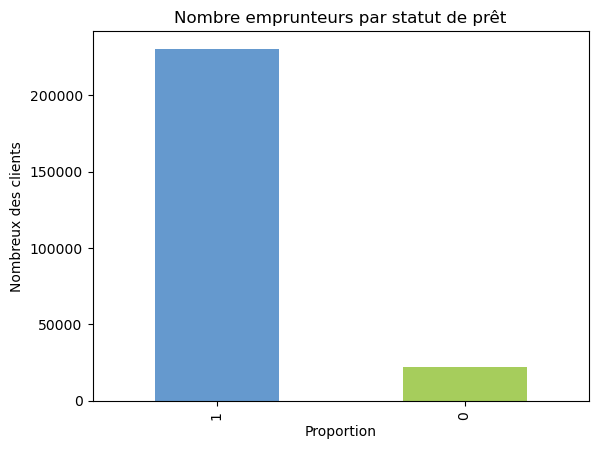

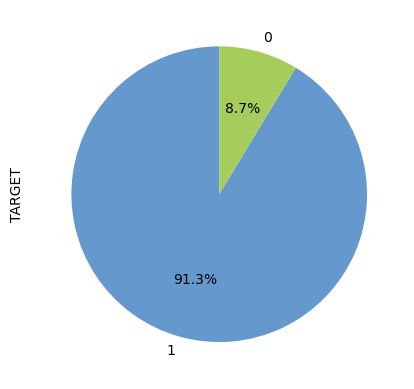

In [36]:
#y.replace(to_replace=[1,0], value= ['YES','NO'], inplace = True)
fig11=plt.figure()
ax11=plt.axes()
colors = ['#6599CE','#A6CD5C']
plt.title('Nombre emprunteurs par statut de prêt')
ax11 = ax11.set(xlabel='Proportion', ylabel='Nombreux des clients')   
y.value_counts().plot.bar(color=colors)
fig12=plt.figure()
ax12=plt.axes()    
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%',colors=colors )
plt.show()
